Comparing different Methods for hard-example mining in `Recv` method

In [1]:
import os
os.chdir("..")

In [2]:
from shell.datasets.datasets import get_dataset
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from shell.utils.utils import seed_everything, viz_embedding
import torch
import subprocess
import torch.nn as nn
import torch
from omegaconf import DictConfig
from shell.datasets.datasets import get_dataset
from shell.utils.utils import seed_everything
from pprint import pprint
from shell.fleet.network import TopologyGenerator
from shell.models.cnn_soft_lifelong_dynamic import CNNSoftLLDynamic
from shell.models.cnn import CNN
from shell.models.mlp import MLP
from shell.models.mlp_soft_lifelong_dynamic import MLPSoftLLDynamic
from shell.learners.er_dynamic import CompositionalDynamicER
from shell.learners.er_nocomponents import NoComponentsER
from shell.utils.experiment_utils import eval_net
from shell.utils.experiment_utils import setup_experiment
from sklearn.manifold import TSNE
import logging
import seaborn as sns
from shell.fleet.recv import least_confidence_scorer, entropy_scorer, margin_scorer, cross_entropy_scorer
import pickle
logging.basicConfig(level=logging.INFO)

In [3]:
def train(dataset_name, seed, from_scratch=True):
    seed_everything(seed)

    if dataset_name == "cifar100":
        num_tasks = 4
        # contrastive is taking too long to train
        # for this simple ablation
        use_contrastive = True
        data_cfg = {
            "dataset_name": dataset_name,
            "num_tasks": num_tasks,
            "num_train_per_task": 256 * 5,
            "num_classes_per_task": 5,
            "num_val_per_task": 102,
            'remap_labels': True,
            'use_contrastive': use_contrastive,
        }

    else:
        num_tasks = 1
        use_contrastive = True
        data_cfg = {
            "dataset_name": dataset_name,
            "num_tasks": num_tasks,
            "num_train_per_task": 128,
            "num_val_per_task": 102,
            'remap_labels': True,
            'use_contrastive': use_contrastive,
        }
    dataset = get_dataset(**data_cfg)

    if dataset_name == "cifar100":
        net_cfg = {
        'depth': 4,
        'num_init_tasks': num_tasks,
        'num_classes': 5,
        'num_tasks': num_tasks,
        "channels": 50,
        "conv_kernel": 3,
        "maxpool_kernel": 2,
        "padding": 1,
        "i_size": 32,
        'dropout': 0.0,
    }
        net = CNN(**net_cfg)
    
    else:
        net_cfg = {
        'depth': 2,
        'layer_size': 64,
        'num_init_tasks': -1,
        'i_size': 28,
        'num_classes': 2,
        'num_tasks': num_tasks,
        'dropout': 0.0,
    }
        net = MLP(**net_cfg)

    agent_cfg = {
        'memory_size': 64,
        'use_contrastive': use_contrastive,
    }
    agent = NoComponentsER(net, **agent_cfg)


    if dataset_name == "cifar100":
        num_epochs = 50 
    else:
        num_epochs = 200

    if from_scratch:
        for task_id in range(num_tasks):
            testloaders = {task: torch.utils.data.DataLoader(testset,
                                                            batch_size=128,
                                                            shuffle=False,
                                                            num_workers=0,
                                                            pin_memory=True,
                                                            ) for task, testset in enumerate(dataset.testset[:(task_id+1)])}

            trainloader = torch.utils.data.DataLoader(dataset.trainset[task_id],
                                                        batch_size=64,
                                                        shuffle=True,
                                                        num_workers=0,
                                                        pin_memory=True,
                                                        )
            agent.train(trainloader, task_id=task_id, num_epochs=num_epochs, testloaders=testloaders,
                            save_freq=1)
    return agent, dataset

In [4]:
def calculate_scores(agent, valset):
    scorer = {
        'least_confidence': least_confidence_scorer,
        'entropy': entropy_scorer,
        'margin': margin_scorer,
        'cross_entropy': cross_entropy_scorer,
    }

    X_val, Y_val = valset.tensors

    with torch.inference_mode():
        X_val = X_val.to(agent.net.device)
        Y_val = Y_val.to(agent.net.device)
        logits = agent.net(X_val, task_id=0)
        Y_hat = logits.argmax(dim=1)
        acc = (Y_hat == Y_val).float().mean()
        print("acc:", acc)
    scores = {}
    for name, score_fn in scorer.items():
        scores[name] = score_fn(logits, Y_val)

    return scores

In [5]:
def calculate_agreement(scores):
    top_k = 10

    agreements = np.zeros((len(scores), len(scores)))
    # compute the agreement rate between pairs of scorers
    for name1, score1 in scores.items():
        for name2, score2 in scores.items():
            # if name1 == name2:
            #     continue
            # agreement is defined as the size of the intersection of the top k indices
            top_k_idx1 = score1.topk(top_k)[1]
            top_k_idx2 = score2.topk(top_k)[1]
            agreement = len(set(top_k_idx1.tolist()) & set(top_k_idx2.tolist())) / top_k
            agreements[list(scores.keys()).index(name1), list(scores.keys()).index(name2)] = agreement
    return agreements

In [43]:
num_seeds = 8
dataset_name = "mnist"
# dataset_name = "fashionmnist"
# dataset_name = "kmnist"
# dataset_name = "cifar100"
agents = []
datasets = []
save_dir = os.path.join("ablation_results", "recv", dataset_name)
# from_scratch if save_dir doesn't exist
from_scratch = not os.path.exists(save_dir)

# mean_agreements = np.zeros((num_seeds, 4, 4))
# score_list = []


for seed in range(num_seeds):
    agent, dataset = train(dataset_name, seed, from_scratch=from_scratch)
    agents.append(agent)
    datasets.append(dataset)


#     scores = calculate_scores(agent, dataset.valset[0])
#     agreements = calculate_agreement(scores)
#     mean_agreements[seed] = agreements
#     score_list.append(scores)

# mean_agreements = mean_agreements.mean(axis=0)
# mean_agreements

INFO:root:Class sequence: [5 0 3 4 2 6 7 1 8 9]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 4 1 9 0 7 2 3 8 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [3 9 7 6 4 2 0 8 5 1]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [9 2 8 5 6 3 7 0 1 4]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 6 3 9 7 5 4 1 8 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [1 8 6 9 4 2 0 5 3 7]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [2 3 8 0 5 7 1 4 6 9]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [9 5 7 8 4 3 6 1 0 2]
INFO:root:task 0 :(128, 1, 28, 28)


In [44]:
datasets[0].class_sequence

array([5, 0, 3, 4, 2, 6, 7, 1, 8, 9])

In [45]:
save_dir = os.path.join("ablation_results", "recv", dataset_name)
# # create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# save agents using pickle
if from_scratch:
    print("saving agents")
    with open(os.path.join(save_dir, "agents.pkl"), "wb") as f:
        pickle.dump(agents, f)

In [46]:
del agents
# load agents using pickle
with open(os.path.join(save_dir, "agents.pkl"), "rb") as f:
    agents = pickle.load(f)
print("loaded agents")
agents

loaded agents


In [47]:
mean_agreements = np.zeros((num_seeds, 4, 4))
score_list = []
for seed in range(num_seeds):
    scores = calculate_scores(agents[seed], datasets[seed].valset[0])
    agreements = calculate_agreement(scores)
    mean_agreements[seed] = agreements
    score_list.append(scores)

# average the agreements across seeds
mean_agreements = mean_agreements.mean(axis=0)
mean_agreements

acc: tensor(0.9608, device='cuda:0')
acc: tensor(0.9804, device='cuda:0')
acc: tensor(0.9412, device='cuda:0')
acc: tensor(0.9804, device='cuda:0')
acc: tensor(0.9804, device='cuda:0')
acc: tensor(0.9706, device='cuda:0')
acc: tensor(0.9510, device='cuda:0')
acc: tensor(0.9510, device='cuda:0')


array([[1.  , 1.  , 1.  , 0.85],
       [1.  , 1.  , 1.  , 0.85],
       [1.  , 1.  , 1.  , 0.85],
       [0.85, 0.85, 0.85, 1.  ]])

/tmp/ipykernel_2912092/822008023.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


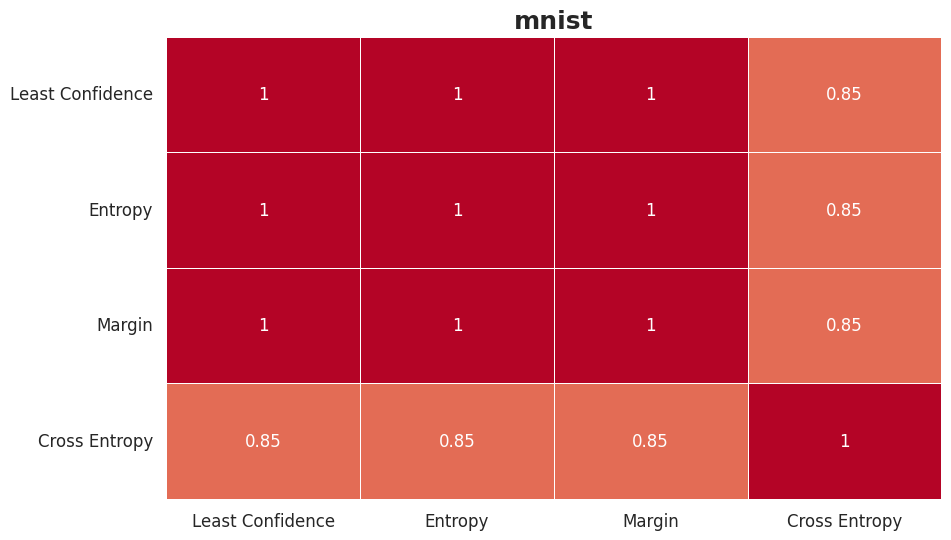

In [48]:
plt.style.use('seaborn-whitegrid')
# plot the agreement matrix
sns.set(style="whitegrid")
scorer_names = ["Least Confidence", "Entropy", "Margin", "Cross Entropy"]

fig, ax = plt.subplots(figsize=(10, 6))

cmap = sns.color_palette(["#3182bd", "#e85a54"], as_cmap=True)

sns.heatmap(mean_agreements, annot=True, xticklabels=scorer_names, yticklabels=scorer_names,
            cmap="coolwarm", cbar=False, linewidths=.5,vmin=0.0, vmax=1.0)
ax.set_title(dataset_name, fontsize=18, fontweight='bold')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), rotation=0)
plt.savefig(f"Figures/recv_appendix/agreement_rate_{dataset_name}.pdf", bbox_inches='tight', pad_inches=0.1)

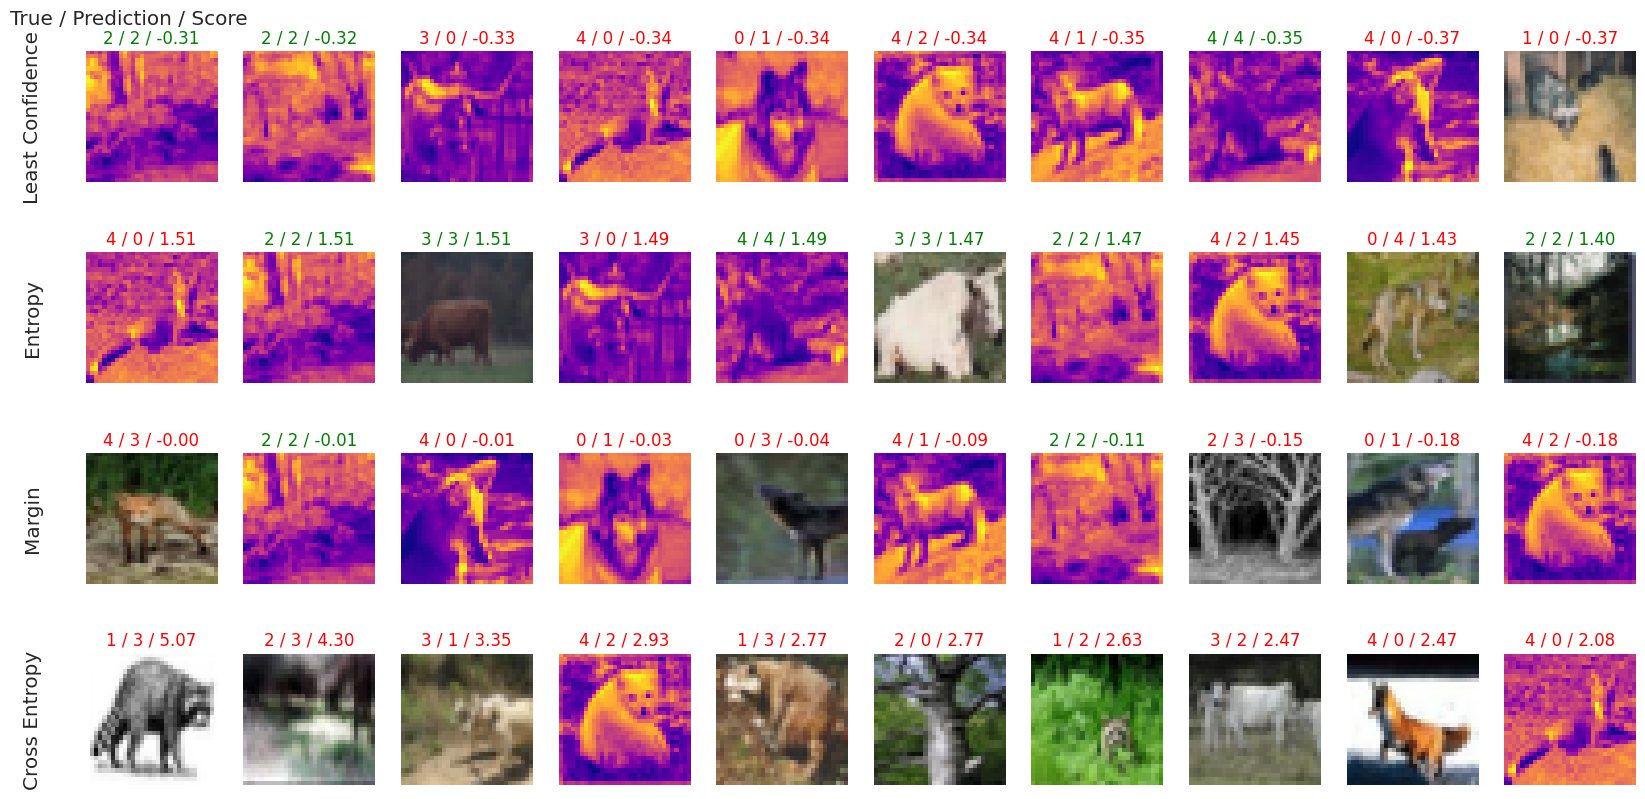

In [29]:
top_k = 10

agent_id = 0
agent = agents[agent_id]
dataset = datasets[agent_id]
scores = score_list[agent_id]
valset = dataset.valset[0]
X_val, Y_val = valset.tensors
X_val = X_val.to(agent.net.device)
Y_val = Y_val.to(agent.net.device)

with torch.inference_mode():
    logits = agent.net(X_val, task_id=0)
    Y_hat = logits.argmax(dim=1)

# for each name, get the top k indices with their scores, plot them annotated with their scores
# create subplots
fig, axs = plt.subplots(len(scores), top_k, figsize=(20, 10))
rows = scorer_names

pad = 0

cols = ["True / Prediction / Score"]

for ax, col in zip(axs[0], cols):
    ax.text(10.0, -7.0, col, fontsize='large', ha='center')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)


if dataset_name == "cifar100":
    i_size = 32
    channels = 3
else:
    i_size = 28
    channels = 1

top_k_idx_each = {}
for j, (name, score) in enumerate(scores.items()):
    top_k_idx = score.topk(top_k)[1]
    top_k_idx_each[name] = top_k_idx.tolist()
# construct top_k_idx_shared where top_k_idx_shared[name] is a list of indices that are shared by all scorers
# excluding name
top_k_idx_shared = {}
for name in scores.keys():
    top_k_idx_shared[name] = []
    for name2 in scores.keys():
        if name != name2:
            top_k_idx_shared[name].extend(top_k_idx_each[name2])
    top_k_idx_shared[name] = set(top_k_idx_shared[name])


for j, (name, score) in enumerate(scores.items()):
    top_k_idx = score.topk(top_k)[1]
    top_k_scores = score[top_k_idx]
    top_k_images = X_val[top_k_idx]
    top_k_images = top_k_images.view(-1, channels, i_size, i_size)
    # plot the top_k_images along with true and predicted labels
    top_k_y = Y_val[top_k_idx]
    top_k_y_hat = Y_hat[top_k_idx]
    for i in range(top_k):
        img = top_k_images[i].cpu().permute(1, 2, 0).squeeze()
        cmap = "gray"
        if top_k_idx[i].item() in top_k_idx_shared[name]:
            cmap = "plasma"
            if channels == 3:
                # convert to grayscale
                img = img.mean(dim=2)
        axs[j, i].imshow(img, cmap=cmap)
        true = top_k_y[i].item()
        pred = top_k_y_hat[i].item()
        color = "green" if true == pred else "red"
        score = top_k_scores[i].item()
        axs[j, i].set_title(f"{true} / {pred} / {score:.2f}", color=color) 
        axs[j,i].axis('off')



plt.savefig(f"Figures/recv_appendix/viz_{dataset_name}.pdf", bbox_inches='tight', pad_inches=0.1)
